# Optical RL-Gym

## Using heuristics to solve the RMSA environment

Before running this notebook make sure to have installed `pandas` and `stable_baselines3` in your Python environment, in addition to the other dependencies of this library.

### Imports

In [1]:
# general imports

import os
import pickle
from typing import Tuple
from multiprocessing import Process

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# environment import
import gym
from stable_baselines3.common.monitor import Monitor

from optical_rl_gym.utils import evaluate_heuristic, random_policy
from optical_rl_gym.envs.rmsa_env import RMSAEnv

### Setting up the environment

In [2]:
# loading the topology binary file containing the graph and the k-shortest paths
# if you want to generate your own binary topology file, check examples/create_topology_rmsa.py
topology_name = 'nsfnet_chen_eon'
k_paths = 5
with open(f'../topologies/{topology_name}_{k_paths}-paths.h5', 'rb') as f:
    topology = pickle.load(f)

# node probabilities from https://github.com/xiaoliangchenUCD/DeepRMSA/blob/6708e9a023df1ec05bfdc77804b6829e33cacfe4/Deep_RMSA_A3C.py#L77
node_request_probabilities = np.array([0.01801802, 0.04004004, 0.05305305, 0.01901902, 0.04504505,
       0.02402402, 0.06706707, 0.08908909, 0.13813814, 0.12212212,
       0.07607608, 0.12012012, 0.01901902, 0.16916917])

number_episodes = 50_000
monitor_info_keywords=('episode_service_blocking_rate','episode_bit_rate_blocking_rate')
plotting_average_window = 50

# mean_service_holding_time=7.5,
env_args = dict(topology=topology, seed=10, 
                allow_rejection=False, # the agent cannot proactively reject a request
                load=55,
                num_spectrum_resources=64,
                episode_length=50, node_request_probabilities=node_request_probabilities)

# Create log dir
log_dir = "./bkp/rmsa-heu/"
os.makedirs(log_dir, exist_ok=True)

### Running the environment for a random policy

In [3]:
def run_random_policy():
    env = gym.make('RMSA-v0', **env_args)

    # logs will be saved in log_dir/sp_ff.monitor.csv
    # in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
    env_rnd = Monitor(env, log_dir + 'rnd', info_keywords=monitor_info_keywords)
    # for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor

    # run the heuristic for a number of episodes
    mean_reward_rnd, std_reward_rnd = evaluate_heuristic(env_rnd, random_policy, n_eval_episodes=number_episodes)
    print('Rnd:'.ljust(8), f'{mean_reward_rnd:.4f}  {std_reward_rnd:>7.4f}')
    print('Bit rate blocking:', (env_rnd.episode_bit_rate_requested - env_rnd.episode_bit_rate_provisioned) / env_rnd.episode_bit_rate_requested)
    print('Request blocking:', (env_rnd.episode_services_processed - env_rnd.episode_services_accepted) / env_rnd.episode_services_processed)

### Running the environment for Shortest-Path First-Fit (SP-FF) heuristic

This heuristic only accepts the shortest path for, e.g., latency-critical applications.

In [4]:
# importing the heuristic algorithm
from optical_rl_gym.envs.rmsa_env import shortest_path_first_fit

def run_sp_ff():
    env = gym.make('RMSA-v0', **env_args)

    # logs will be saved in log_dir/sp_ff.monitor.csv
    # in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
    env_sp_ff = Monitor(env, log_dir + 'sp_ff', info_keywords=monitor_info_keywords)
    # for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor

    # run the heuristic for a number of episodes
    mean_reward_sp_ff, std_reward_sp_ff = evaluate_heuristic(env_sp_ff, shortest_path_first_fit, n_eval_episodes=number_episodes)
    print('SP-FF:'.ljust(8), f'{mean_reward_sp_ff:.4f}  {std_reward_sp_ff:>7.4f}')
    print('Bit rate blocking:', (env_sp_ff.episode_bit_rate_requested - env_sp_ff.episode_bit_rate_provisioned) / env_sp_ff.episode_bit_rate_requested)
    print('Request blocking:', (env_sp_ff.episode_services_processed - env_sp_ff.episode_services_accepted) / env_sp_ff.episode_services_processed)

### Running the environment for Shortest-Available-Path First-Fit (SAP-FF) heuristic

This heuristic is also known as *k*-shortest-paths first-fit.

In [5]:
# importing the heuristic algorithm
from optical_rl_gym.envs.rmsa_env import shortest_available_path_first_fit

def run_sap_ff():
    env = gym.make('RMSA-v0', **env_args)

    # logs will be saved in log_dir/sp_ff.monitor.csv
    # in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
    env_sap_ff = Monitor(env, log_dir + 'sap_ff', info_keywords=monitor_info_keywords)
    # for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor

    # run the heuristic for a number of episodes
    mean_reward_sap_ff, std_reward_sap_ff = evaluate_heuristic(env_sap_ff, shortest_available_path_first_fit, n_eval_episodes=number_episodes)
    print('SAP-FF:'.ljust(8), f'{mean_reward_sap_ff:.4f}  {std_reward_sap_ff:>7.4f}')
    print('Bit rate blocking:', (env_sap_ff.episode_bit_rate_requested - env_sap_ff.episode_bit_rate_provisioned) / env_sap_ff.episode_bit_rate_requested)
    print('Request blocking:', (env_sap_ff.episode_services_processed - env_sap_ff.episode_services_accepted) / env_sap_ff.episode_services_processed)

### Running the environment for Least-Loaded-Path First-Fit (LLP-FF) heuristic

This heuristic does load balancing by selecting the of the *k* shortest-paths that has the least number of slots occupied.

In [6]:
# importing the heuristic algorithm
from optical_rl_gym.envs.rmsa_env import least_loaded_path_first_fit

def run_llp_ff():
    env = gym.make('RMSA-v0', **env_args)

    # logs will be saved in log_dir/sp_ff.monitor.csv
    # in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
    env_llp_ff = Monitor(env, log_dir + 'llp_ff', info_keywords=monitor_info_keywords)
    # for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor

    # run the heuristic for a number of episodes
    mean_reward_llp_ff, std_reward_llp_ff = evaluate_heuristic(env_llp_ff, least_loaded_path_first_fit, n_eval_episodes=number_episodes)
    print('LLP-FF:'.ljust(8), f'{mean_reward_llp_ff:.4f}  {std_reward_llp_ff:>7.4f}')
    print('Bit rate blocking:', (env_llp_ff.episode_bit_rate_requested - env_llp_ff.episode_bit_rate_provisioned) / env_llp_ff.episode_bit_rate_requested)
    print('Request blocking:', (env_llp_ff.episode_services_processed - env_llp_ff.episode_services_accepted) / env_llp_ff.episode_services_processed)

In [7]:
processes = []

p = Process(target=run_random_policy)
p.start()
processes.append(p)

p = Process(target=run_sp_ff)
p.start()
processes.append(p)

p = Process(target=run_sap_ff)
p.start()
processes.append(p)

p = Process(target=run_llp_ff)
p.start()
processes.append(p)

# wait for all processes to finish
[p.join() for p in processes]

Rnd:     13.5365   3.0535
Bit rate blocking: 0.7331189710610932
Request blocking: 0.72
SP-FF:   42.2243   3.4363
Bit rate blocking: 0.15144694533762057
Request blocking: 0.14
SAP-FF:  46.0713   2.6681
Bit rate blocking: 0.0864951768488746
Request blocking: 0.06
LLP-FF:  46.3170   2.7609
Bit rate blocking: 0.13311897106109324
Request blocking: 0.1


[None, None, None, None]

## Plotting the results

### Reading the data from the environment monitor

In [8]:
rnd_data = pd.read_csv(log_dir + 'rnd.monitor.csv', skiprows=1)
sp_ff_data = pd.read_csv(log_dir + 'sp_ff.monitor.csv', skiprows=1)
sap_ff_data = pd.read_csv(log_dir + 'sap_ff.monitor.csv', skiprows=1)
llp_ff_data = pd.read_csv(log_dir + 'llp_ff.monitor.csv', skiprows=1)
rnd_data.describe()

,r,l,t,episode_service_blocking_rate,episode_bit_rate_blocking_rate
count,50000.00000,50000.0,50000.000000,50000.000000,50000.000000
mean,13.53654,50.0,834.719009,0.729269,0.746907
std,3.05357,0.0,481.447159,0.061071,0.061742
min,2.00000,50.0,0.045995,0.460000,0.458489
25%,11.00000,50.0,418.016881,0.680000,0.706091
50%,13.00000,50.0,834.124077,0.740000,0.748652
75%,16.00000,50.0,1251.364716,0.780000,0.789642
max,27.00000,50.0,1668.599873,0.960000,0.962043


### Generating plots

We use `np.convolve` to smoothen the curve having the `plotting_average_window` as the parameter.

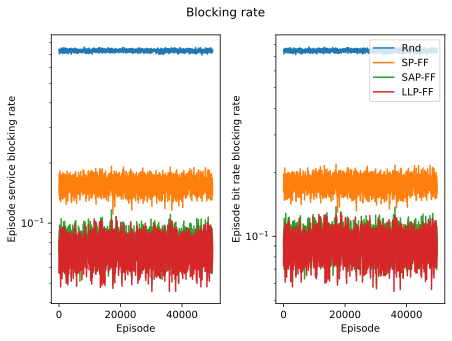

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Blocking rate')

ax1.semilogy(np.convolve(rnd_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='Rnd')
ax1.semilogy(np.convolve(sp_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SP-FF')
ax1.semilogy(np.convolve(sap_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SAP-FF')
ax1.semilogy(np.convolve(llp_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='LLP-FF')

ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode service blocking rate')

ax2.semilogy(np.convolve(rnd_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='Rnd')
ax2.semilogy(np.convolve(sp_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SP-FF')
ax2.semilogy(np.convolve(sap_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SAP-FF')
ax2.semilogy(np.convolve(llp_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='LLP-FF')

ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode bit rate blocking rate')

plt.legend(loc=1)
plt.tight_layout()
plt.savefig(log_dir + "blocking.pdf")
plt.savefig(log_dir + "blocking.svg")
plt.show()

## Creating your own heuristic

### Stateless heuristic

In [10]:
# creating the heuristic function
def most_loaded_path_first_fit(env: RMSAEnv) -> Tuple[int, int]:
    max_free_slots = 1000
    action = (env.topology.graph['k_paths'], env.topology.graph['num_spectrum_resources'])
    for idp, path in enumerate(env.k_shortest_paths[env.service.source, env.service.destination]):
        num_slots = env.get_number_slots(path)
        for initial_slot in range(0, env.topology.graph['num_spectrum_resources'] - num_slots):
            if env.is_path_free(path, initial_slot, num_slots):
                free_slots = np.sum(env.get_available_slots(path))
                if free_slots < max_free_slots:
                    action = (idp, initial_slot)
                    max_free_slots = free_slots
                break # breaks the loop for the initial slot
    return action

In [11]:
env = gym.make('RMSA-v0', **env_args)

# logs will be saved in log_dir/sp_ff.monitor.csv
# in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
env_mlp_ff = Monitor(env, log_dir + 'mlp_ff', info_keywords=monitor_info_keywords)
# for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor

# run the heuristic for a number of episodes
mean_reward_mlp_ff, std_reward_mlp_ff = evaluate_heuristic(env_mlp_ff, most_loaded_path_first_fit, n_eval_episodes=number_episodes)
print('MLP-FF:'.ljust(8), f'{mean_reward_mlp_ff:.4f}  {std_reward_mlp_ff:>7.4f}')
print('Bit rate blocking:', (env_mlp_ff.episode_bit_rate_requested - env_mlp_ff.episode_bit_rate_provisioned) / env_mlp_ff.episode_bit_rate_requested)
print('Request blocking:',  (env_mlp_ff.episode_services_processed - env_mlp_ff.episode_services_accepted) / env_mlp_ff.episode_services_processed)

MLP-FF:  41.5945   3.1091
Bit rate blocking: 0.18938906752411575
Request blocking: 0.16


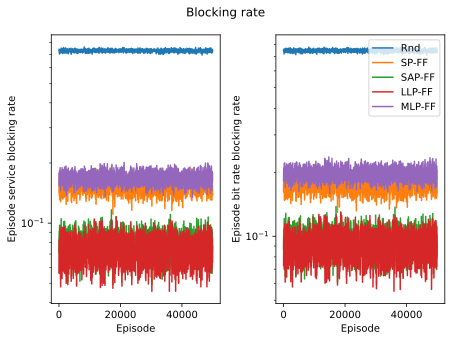

In [12]:
mlp_ff_data = pd.read_csv(log_dir + 'mlp_ff.monitor.csv', skiprows=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Blocking rate')

ax1.semilogy(np.convolve(rnd_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='Rnd')
ax1.semilogy(np.convolve(sp_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SP-FF')
ax1.semilogy(np.convolve(sap_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SAP-FF')
ax1.semilogy(np.convolve(llp_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='LLP-FF')
ax1.semilogy(np.convolve(mlp_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='MLP-FF')

ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode service blocking rate')

ax2.semilogy(np.convolve(rnd_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='Rnd')
ax2.semilogy(np.convolve(sp_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SP-FF')
ax2.semilogy(np.convolve(sap_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SAP-FF')
ax2.semilogy(np.convolve(llp_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='LLP-FF')
ax2.semilogy(np.convolve(mlp_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='MLP-FF')

ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode bit rate blocking rate')

plt.legend(loc=1)
plt.tight_layout()
plt.savefig(log_dir + "blocking-mlp.pdf")
plt.savefig(log_dir + "blocking-mlp.svg")
plt.show()

### Stateful heuristic

If you need a *stateful* heuristic, i.e., the heuristic needs to keep state between computations, you need to create a class. The state is maintained by the attributes of the class, and you need a method with the same signature of the heuristic functions.

In [13]:
class ShortestLongestPathFirstFit:

    # in this example, the state is a simple counter
    # of the provisioned requests
    counter: int = 0

    # this method exposes the same signature
    # note that you can add other (internal) methods to this class
    def compute(self, env: RMSAEnv) -> Tuple[int, int]:
        self.counter += 1
        if self.counter % 2 == 0:
            # shortest
            for idp, path in enumerate(env.k_shortest_paths[env.service.source, env.service.destination]):
                num_slots = env.get_number_slots(path)
                for initial_slot in range(0, env.topology.graph['num_spectrum_resources'] - num_slots):
                    if env.is_path_free(path, initial_slot, num_slots):
                        return (idp, initial_slot)
            return (env.topology.graph['k_paths'], env.topology.graph['num_spectrum_resources'])
        else:
            # longest
            for idp, path in enumerate(reversed(env.k_shortest_paths[env.service.source, env.service.destination])):
                num_slots = env.get_number_slots(path)
                for initial_slot in range(0, env.topology.graph['num_spectrum_resources'] - num_slots):
                    if env.is_path_free(path, initial_slot, num_slots):
                        return (idp, initial_slot)
            return (env.topology.graph['k_paths'], env.topology.graph['num_spectrum_resources'])

In [14]:
env = gym.make('RMSA-v0', **env_args)

# logs will be saved in log_dir/sp_ff.monitor.csv
# in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
env_slap_ff = Monitor(env, log_dir + 'slap_ff', info_keywords=monitor_info_keywords)
# for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor

# create an instance of the heuristic
slap_heuristic = ShortestLongestPathFirstFit()

# run the heuristic for a number of episodes
mean_reward_slap_ff, std_reward_slap_ff = evaluate_heuristic(env_slap_ff, slap_heuristic.compute, n_eval_episodes=number_episodes)
print('SLAP-FF:'.ljust(8), f'{mean_reward_slap_ff:.4f}  {std_reward_slap_ff:>7.4f}')
print('Bit rate blocking:', (env_slap_ff.episode_bit_rate_requested - env_slap_ff.episode_bit_rate_provisioned) / env_slap_ff.episode_bit_rate_requested)
print('Request blocking:',  (env_slap_ff.episode_services_processed - env_slap_ff.episode_services_accepted) / env_slap_ff.episode_services_processed)

SLAP-FF: 34.3571   3.0491
Bit rate blocking: 0.3183279742765273
Request blocking: 0.28


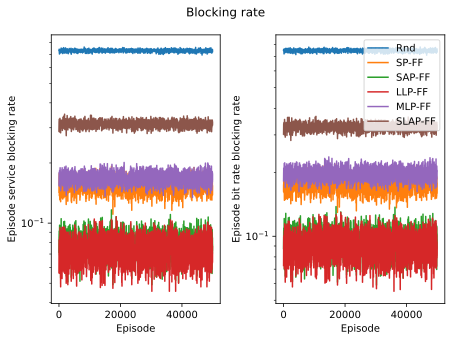

In [15]:
slap_ff_data = pd.read_csv(log_dir + 'slap_ff.monitor.csv', skiprows=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Blocking rate')

ax1.semilogy(np.convolve(rnd_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='Rnd')
ax1.semilogy(np.convolve(sp_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SP-FF')
ax1.semilogy(np.convolve(sap_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SAP-FF')
ax1.semilogy(np.convolve(llp_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='LLP-FF')
ax1.semilogy(np.convolve(mlp_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='MLP-FF')
ax1.semilogy(np.convolve(slap_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SLAP-FF')

ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode service blocking rate')

ax2.semilogy(np.convolve(rnd_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='Rnd')
ax2.semilogy(np.convolve(sp_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SP-FF')
ax2.semilogy(np.convolve(sap_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SAP-FF')
ax2.semilogy(np.convolve(llp_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='LLP-FF')
ax2.semilogy(np.convolve(mlp_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='MLP-FF')
ax2.semilogy(np.convolve(slap_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SLAP-FF')

ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode bit rate blocking rate')

plt.legend(loc=1)
plt.tight_layout()
plt.savefig(log_dir + "blocking-slap.pdf")
plt.savefig(log_dir + "blocking-slap.svg")
plt.show()